<a href="https://colab.research.google.com/github/mar25-iia2-radiographies/01_data_exploration/blob/main/01_data_exploration_romuald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploration de la structure du dossier

In [9]:
import kagglehub
from pathlib import Path
import os

# Download latest version of the dataset
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
print("Le dataset a été téléchargé ici :", path)

base_path = Path(path)
data_path = base_path / "COVID-19_Radiography_Dataset"

print("\n" + "="*80)
print("STRUCTURE COMPLÈTE - TOUS DOSSIERS/SOUS-DOSSIERS")
print("="*80)

# 1. RACINE
print("\n📁 RACINE:")
for item in sorted(base_path.iterdir()):
    print(f"  {item.name} ({item.stat().st_size/1024/1024:.1f}MB)")

# 2. EXPLORATION RÉCURSIVE COMPLÈTE
print("\n📂 ARBRE COMPLET (3 niveaux max):")
def print_tree(path, prefix="", max_depth=3, current_depth=0):
    if current_depth > max_depth:
        return

    items = sorted(path.iterdir())
    for i, item in enumerate(items):
        is_last = i == len(items) - 1
        connector = "└── " if is_last else "├── "
        print(f"{prefix}{connector}{item.name}")

        if item.is_dir():
            new_prefix = prefix + ("    " if is_last else "│   ")
            print_tree(item, new_prefix, max_depth, current_depth + 1)

print_tree(base_path, max_depth=2)

# 3. COMPTE IMAGES PAR DOSSIER
print("\n📊 COMPTE IMAGES PAR DOSSIER:")
def count_images_recursively(root):
    for root_dir, dirs, files in os.walk(root):
        png_count = len([f for f in files if f.lower().endswith('.png')])
        jpg_count = len([f for f in files if f.lower().endswith('.jpg')])

        if png_count + jpg_count > 0:
            rel_path = os.path.relpath(root_dir, base_path)
            print(f"  {rel_path:<40} : {png_count:>4} PNG + {jpg_count:>4} JPG = {png_count+jpg_count:>5} total")

count_images_recursively(base_path)

# 4. RÉSUMÉ FINAL
print("\n" + "="*80)
print("RÉSUMÉ FINAL")
print("="*80)
categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
total_images = 0

for cat in categories:
    cat_path = data_path / cat
    if cat_path.exists():
        all_images = list(cat_path.rglob('*.png')) + list(cat_path.rglob('*.jpg'))
        count = len(all_images)
        total_images += count
        print(f"✅ {cat}: {count:,} images")
        if count > 0:
            print(f"   Premier: {all_images[0].name}")
    else:
        print(f"❌ {cat}: DOSSIER MANQUANT")

print(f"\n🎯 TOTAL IMAGES: {total_images:,}")



Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Le dataset a été téléchargé ici : /kaggle/input/covid19-radiography-database

STRUCTURE COMPLÈTE - TOUS DOSSIERS/SOUS-DOSSIERS

📁 RACINE:
  COVID-19_Radiography_Dataset (0.0MB)

📂 ARBRE COMPLET (3 niveaux max):
└── COVID-19_Radiography_Dataset
    ├── COVID
    │   ├── images
    │   └── masks
    ├── COVID.metadata.xlsx
    ├── Lung_Opacity
    │   ├── images
    │   └── masks
    ├── Lung_Opacity.metadata.xlsx
    ├── Normal
    │   ├── images
    │   └── masks
    ├── Normal.metadata.xlsx
    ├── README.md.txt
    ├── Viral Pneumonia
    │   ├── images
    │   └── masks
    └── Viral Pneumonia.metadata.xlsx

📊 COMPTE IMAGES PAR DOSSIER:
  COVID-19_Radiography_Dataset/Normal/images : 10192 PNG +    0 JPG = 10192 total
  COVID-19_Radiography_Dataset/Normal/masks : 10192 PNG +    0 JPG = 10192 total
  COVID-19_Radiography_Dataset/Lung_Opacity/images : 6012 PNG +    0 JPG =  6012 total
  COVID-19_Radiogra

Création du dataset

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# CHEMINS EXACTS
base_path = Path("/kaggle/input/covid19-radiography-database")
data_path = base_path / "COVID-19_Radiography_Dataset"

categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Dataset de travail : SEULEMENT images/
image_paths = {}
for cat in categories:
    image_paths[cat] = list((data_path / cat / 'images').rglob('*.png'))
    print(f"✅ {cat}: {len(image_paths[cat]):,} images")

print(f"\n🎯 TOTAL: {sum(len(v) for v in image_paths.values()):,} images")


✅ COVID: 3,616 images
✅ Normal: 10,192 images
✅ Lung_Opacity: 6,012 images
✅ Viral Pneumonia: 1,345 images

🎯 TOTAL: 21,165 images


1. Vérification Grayscale + Tailles (TRié par Catégorie)

=== VÉRIFICATION GRAYSCALE (100 images/catégorie) ===

COVID: 100 images analysées
  COVID-1994.png: L
  COVID-1825.png: L
  COVID-517.png: L

Normal: 100 images analysées

Lung_Opacity: 100 images analysées

Viral Pneumonia: 100 images analysées

=== RÉSULTAT GRAYSCALE PAR CATÉGORIE ===
          category  total_checked  grayscale  color  pct_grayscale
0            COVID            100        100      0          100.0
1           Normal            100        100      0          100.0
2     Lung_Opacity            100        100      0          100.0
3  Viral Pneumonia            100         88     12           88.0

🎯 TOTAL ANALYSÉ: 400 images
   Grayscale: 388 (97.0%)
   Couleur:   12 (3.0%)


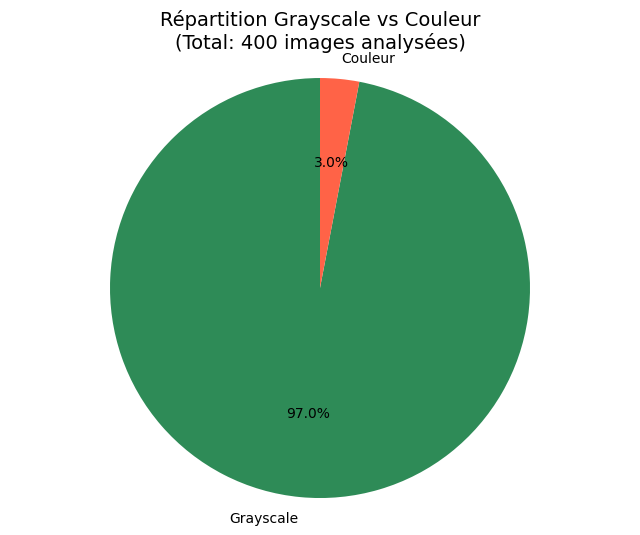

In [12]:
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Chemins exacts
base_path = Path("/kaggle/input/covid19-radiography-database")
data_path = base_path / "COVID-19_Radiography_Dataset"
categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

print("=== VÉRIFICATION GRAYSCALE (100 images/catégorie) ===")

grayscale_stats = []
total_grayscale, total_color = 0, 0

for cat in categories:
    cat_path = data_path / cat / 'images'
    images = list(cat_path.glob('*.png'))[:100]

    print(f"\n{cat}: {len(images)} images analysées")
    g_count, c_count = 0, 0

    for img_path in images:
        try:
            with Image.open(img_path) as img:
                if img.mode == 'L':
                    g_count += 1
                    total_grayscale += 1
                else:
                    c_count += 1
                    total_color += 1

                if len(grayscale_stats) == 0 and g_count + c_count <= 3:
                    print(f"  {img_path.name}: {img.mode}")
        except:
            pass

    grayscale_stats.append({
        'category': cat,
        'total_checked': len(images),
        'grayscale': g_count,
        'color': c_count,
        'pct_grayscale': g_count / len(images) * 100
    })

grayscale_df = pd.DataFrame(grayscale_stats)
print("\n=== RÉSULTAT GRAYSCALE PAR CATÉGORIE ===")
print(grayscale_df.round(1))

# CAMEMBERT TOTAL
total_images = total_grayscale + total_color
print(f"\n🎯 TOTAL ANALYSÉ: {total_images} images")
print(f"   Grayscale: {total_grayscale} ({total_grayscale/total_images*100:.1f}%)")
print(f"   Couleur:   {total_color} ({total_color/total_images*100:.1f}%)")

plt.figure(figsize=(8, 6))
plt.pie([total_grayscale, total_color],
        labels=['Grayscale', 'Couleur'],
        autopct='%1.1f%%',
        colors=['#2E8B57', '#FF6347'],
        startangle=90)
plt.title(f'Répartition Grayscale vs Couleur\n(Total: {total_images} images analysées)', fontsize=14)
plt.axis('equal')
plt.show()
